In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
#Test Simulation Parameters

n = 5 #Number of Agents
t = 100 #Number of timesteps
p1 = 0.3 #probability of the first bandit giving reward +1
p2 = 0.1 #probability of the second bandit giving reward +1
beta = 4*np.ones(n) #agent's inverse temperature
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 2 #number of simulations

In [34]:
#Functions to simulate
Qval = np.zeros((n,2)) #array to store the Q-values
def softmax(aQ,a_beta): 
    val = 1/(1+np.exp(-a_beta*(aQ[0]-aQ[1]))) #returns the softmax values
    return val,1-val 

def return_action(agent_id,Qval,beta):
    action = np.random.choice([0,1],p = softmax(Qval[agent_id],beta[agent_id])) #chooses action based on softmax values
    return action

def bandit_reward(action):
    pss = [p1,p2] #stored in array for convenience
    return np.random.choice([1,-1],p=[pss[action],1-pss[action]]) #return reward from chosen bandit

def calculateUc(R,P,alpha1,alpha2,Qval,n,action,agent_id): #calculate the change to the Qvalues for chosen action
    val1 = 0
    val2 = 0
    #print(R,P)
    for id in R:
        val1 += (1-Qval[agent_id,action]) #sum over rewarded players 
    val1 = alpha1*val1
    for id in P:
        val2 += (-1-Qval[agent_id,action]) #sum over punished players
    val2 = alpha2*val2
    return (val1+val2)/n

def calculateUu(R,P,alpha1,alpha2,Qval,n,action,agent_id): #calculate the change to the Qvalues for action not selected
    val1 = 0
    val2 = 0
    #print(R,P)
    for id in R:
        val1 += (1-Qval[agent_id,1-action]) #sum over rewarded players 
    val1 = alpha2*val1
    for id in P:
        val2 += (-1-Qval[agent_id,1-action]) #sum over punished players
    val2 = alpha1*val2
    return (val1+val2)/n

def multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta):
    net_reward = 0
    for i in range(t):
        Qval2 = np.copy(Qval)
        rewards = []
        actions = []
        b1_w = []
        b2_w = []
        b1_l = []
        b2_l = []
        for agent_id in range(n):
            action = return_action(agent_id,Qval,beta) #find the action and rewards of the agents
            reward = bandit_reward(action)
            actions.append(action)
            rewards.append(reward)
            if action == 0 and reward == -1: #classify the agents according to the action and rewards
                b1_l.append(agent_id)
            elif action == 0 and reward == 1:
                b1_w.append(agent_id)
            elif action == 1 and reward == -1:
                b2_l.append(agent_id)
            elif action==1 and reward == 1:
                b2_w.append(agent_id)
        net_reward+=sum(rewards)/n
        for agent_id in range(n): #update the q-values for the agent
            aic = actions[agent_id]
            if aic == 0: #set the sets of reward or penalty and action chosen or not chosen for particular agent
                Ric = b1_w
                Pic = b1_l
                Riu = b2_w
                Piu = b2_l
            else:
                Ric = b2_w
                Pic = b2_l
                Riu = b1_w
                Piu = b1_l
            Uc = calculateUc(Ric,Pic,alpha1,alpha2,Qval,n,aic,agent_id) #calculate the changes in Q's
            Uu = calculateUu(Riu,Piu,alpha1,alpha2,Qval,n,aic,agent_id)
            Qval2[agent_id,aic]+=Uc #update the Q values
            Qval2[agent_id,1-aic]+=Uu
        Qval = Qval2
    return net_reward/t

#print(multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta))

def simulateKtimes(K,n,t,alpha1,alpha2,beta): #simulate for K times
    r_simuls = 0
    for k in range(K):
        Qval = np.zeros((n,2)) #array to store the Q-values
        r_simuls+=multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta)
    return r_simuls/K


## Poor conditions, $p_1$ = 0.1, $p_2$ = 0.3, with b = 3, 1, $\frac{1}{3}$

In [ ]:
#Simulation Parameters 

ns = list(range(1,21)) #Number of Agents
t = 100 #Number of timesteps
p1 = 0.1 #probability of the first bandit giving reward +1
p2 = 0.3 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 500 #number of simulations

cperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    cperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for disconfirmation bias

alpha1 = 0.05 #confirmatory learning rate
alpha2 = 0.15 #anti-conrfirmatory learning rate

acperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    acperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for no bias

alpha1 = 0.1 #confirmatory learning rate
alpha2 = 0.1 #anti-conrfirmatory learning rate

nperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    nperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

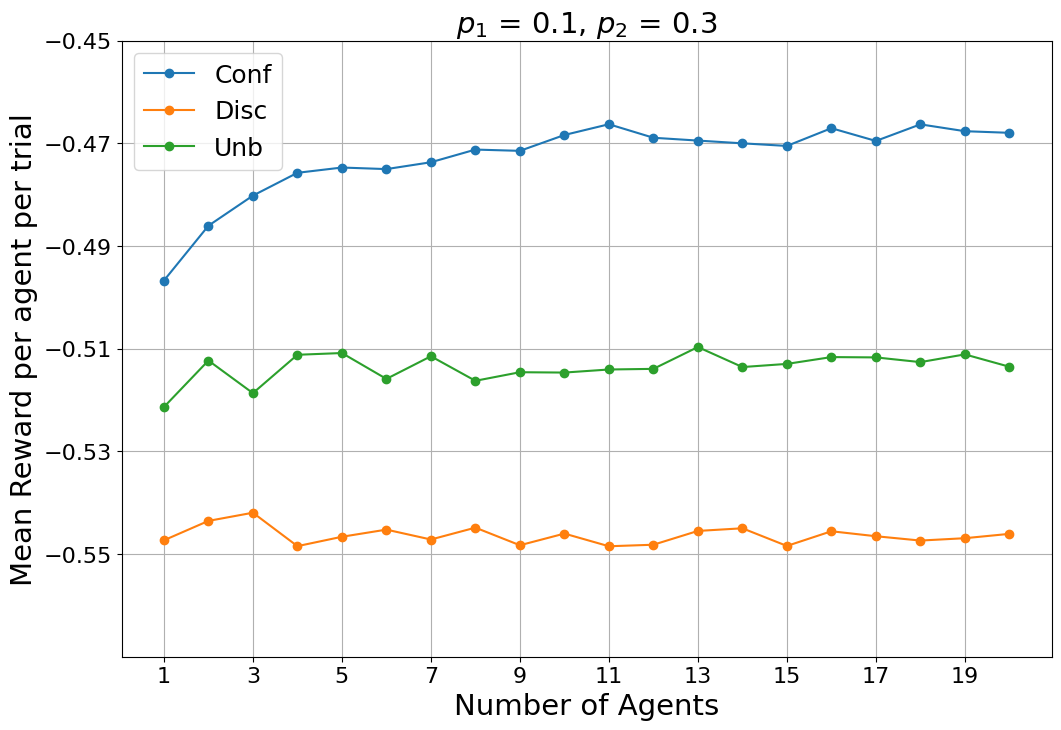

In [36]:
plt.figure(figsize=(12, 8))
lr = round(min(cperf+acperf+nperf),2)
mr = round(max(cperf+acperf+nperf),2)
plt.plot(ns,cperf,"o-",label = "Conf")
plt.plot(ns,acperf,"o-",label = "Disc")
plt.plot(ns,nperf,"o-",label = "Unb")
plt.legend(fontsize = 18)
plt.xlabel("Number of Agents",fontsize = 21)
plt.ylabel("Mean Reward per agent per trial",fontsize = 21)
plt.title(r"$p_1$ = "+str(p1)+r", $p_2$ = "+str(p2),fontsize = 21)
plt.xticks(list(range(1,ns[-1],2)),fontsize = 16)
plt.yticks(np.arange(lr,mr+0.02,0.02),fontsize = 16)
plt.ylim([lr-0.02,mr+0.02])
plt.grid()
plt.savefig("Fig1A.jpg",dpi = 500)


## Mixed conditions, $p_1$ = 0.4, $p_2$ = 0.6, confirmatory bias, b = 3, 1, $\frac{1}{3}$

In [ ]:
#Simulation Parameters 

#ns = list(range(1,7)) #Number of Agents used from prev simulation
t = 100 #Number of timesteps
p1 = 0.4 #probability of the first bandit giving reward +1
p2 = 0.6 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 500 #number of simulations

cperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    cperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for disconfirmation bias

alpha1 = 0.05 #confirmatory learning rate
alpha2 = 0.15 #anti-conrfirmatory learning rate

acperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    acperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for no bias

alpha1 = 0.1 #confirmatory learning rate
alpha2 = 0.1 #anti-conrfirmatory learning rate

nperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    nperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

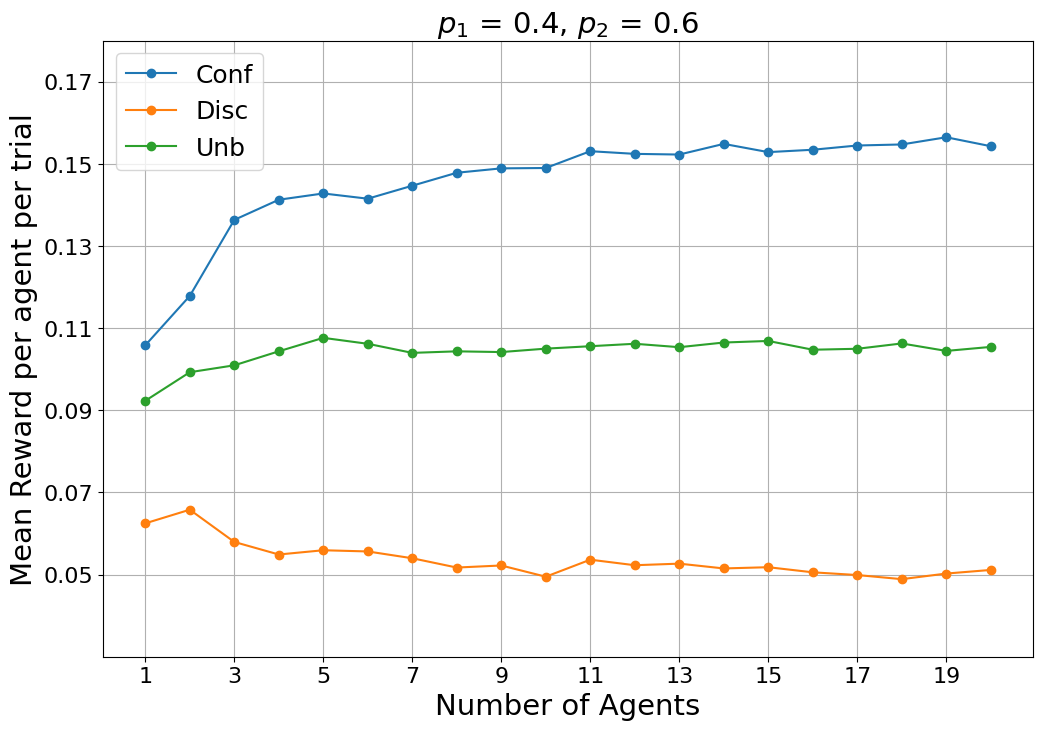

In [38]:
plt.figure(figsize=(12, 8))
lr = round(min(cperf+acperf+nperf),2)
mr = round(max(cperf+acperf+nperf),2)
plt.plot(ns,cperf,"o-",label = "Conf")
plt.plot(ns,acperf,"o-",label = "Disc")
plt.plot(ns,nperf,"o-",label = "Unb")
plt.legend(fontsize = 18)
plt.xlabel("Number of Agents",fontsize = 21)
plt.ylabel("Mean Reward per agent per trial",fontsize = 21)
plt.title(r"$p_1$ = "+str(p1)+r", $p_2$ = "+str(p2),fontsize = 21)
plt.xticks(list(range(1,ns[-1],2)),fontsize = 16)
plt.yticks(np.arange(lr,mr+0.02,0.02),fontsize = 16)
plt.ylim([lr-0.02,mr+0.02])
plt.grid()
plt.savefig("Fig1B.jpg",dpi = 500)


## Abundant conditions, $p_1$ = 0.7, $p_2$ = 0.9, confirmatory bias, b = 3, 1, $\frac{1}{3}$

In [ ]:
#Simulation Parameters 

#ns = list(range(1,7)) #Number of Agents used from prev simulation
t = 100 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 500 #number of simulations

cperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    cperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for disconfirmation bias

alpha1 = 0.05 #confirmatory learning rate
alpha2 = 0.15 #anti-conrfirmatory learning rate

acperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    acperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for no bias

alpha1 = 0.1 #confirmatory learning rate
alpha2 = 0.1 #anti-conrfirmatory learning rate

nperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    nperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

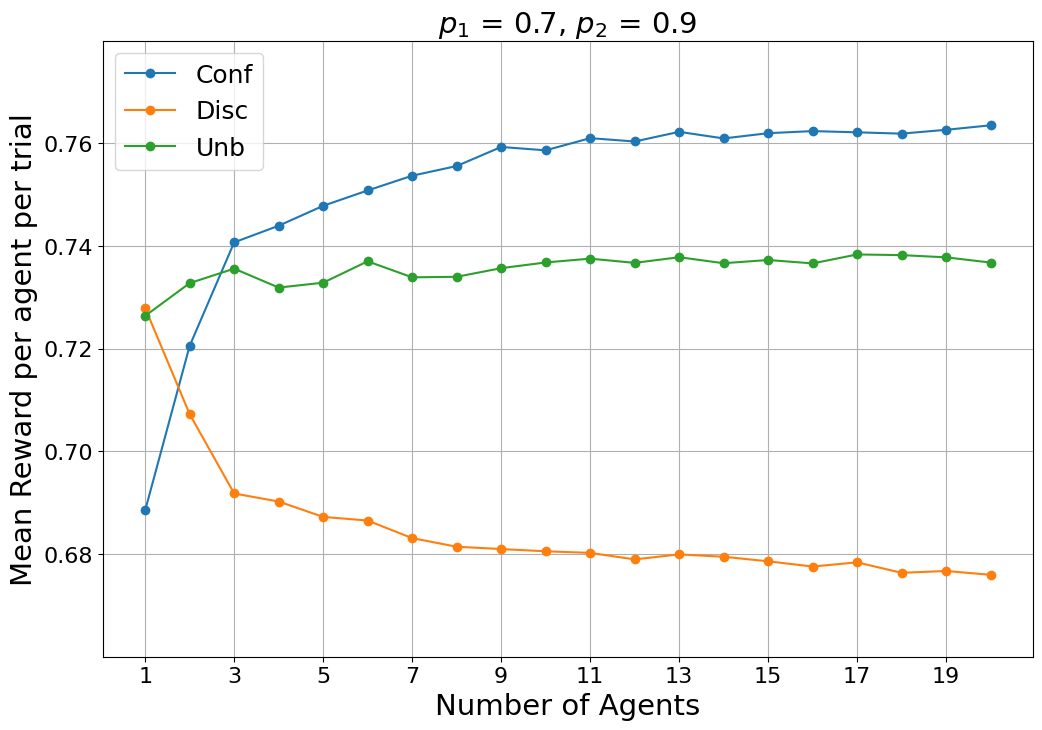

In [40]:
plt.figure(figsize=(12, 8))
lr = round(min(cperf+acperf+nperf),2)
mr = round(max(cperf+acperf+nperf),2)
plt.plot(ns,cperf,"o-",label = "Conf")
plt.plot(ns,acperf,"o-",label = "Disc")
plt.plot(ns,nperf,"o-",label = "Unb")
plt.legend(fontsize = 18)
plt.xlabel("Number of Agents",fontsize = 21)
plt.ylabel("Mean Reward per agent per trial",fontsize = 21)
plt.title(r"$p_1$ = "+str(p1)+r", $p_2$ = "+str(p2),fontsize = 21)
plt.xticks(list(range(1,ns[-1],2)),fontsize = 16)
plt.yticks(np.arange(lr,mr+0.02,0.02),fontsize = 16)
plt.ylim([lr-0.02,mr+0.02])
plt.grid()
plt.savefig("Fig1C.jpg",dpi = 500)

## Abundant conditions, $p_1$ = 0.7, $p_2$ = 0.9, confirmatory bias, b = 3, 1, $\frac{1}{3}$

In [ ]:
#Simulation Parameters for confirmation bias

ns = list(range(1,11)) #Number of Agents used from prev simulation
t = 200 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 500 #number of simulations

cperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    cperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for disconfirmation bias

alpha1 = 0.05 #confirmatory learning rate
alpha2 = 0.15 #anti-conrfirmatory learning rate

acperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    acperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for no bias

alpha1 = 0.1 #confirmatory learning rate
alpha2 = 0.1 #anti-conrfirmatory learning rate

nperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    nperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

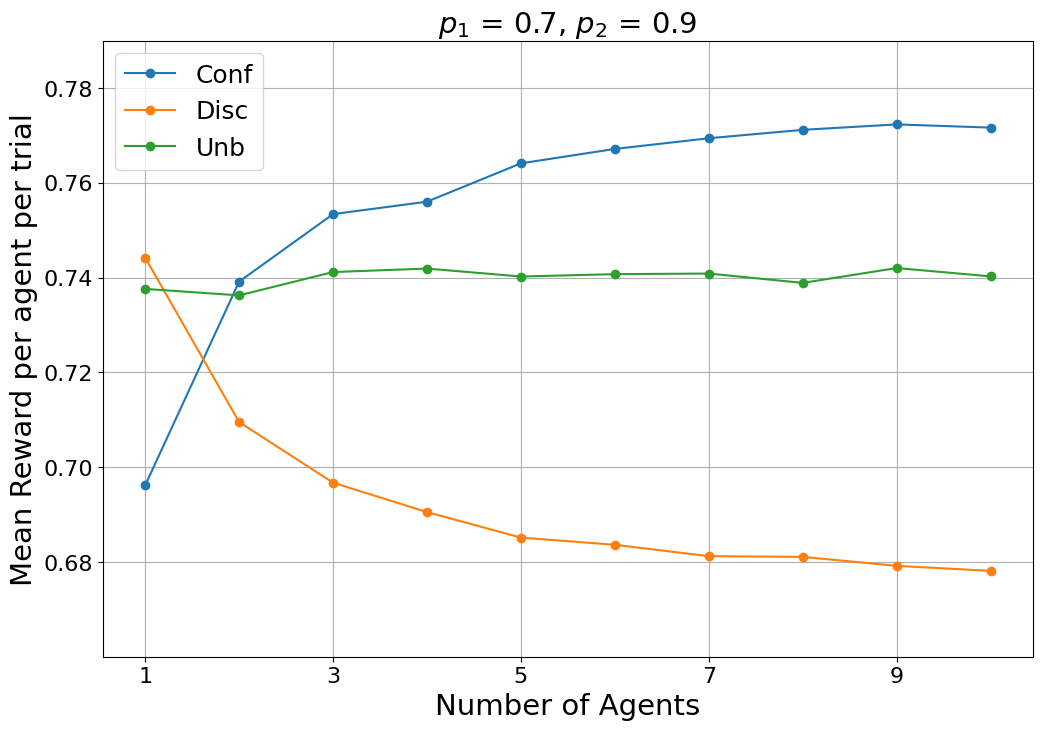

In [42]:
plt.figure(figsize=(12, 8))
lr = round(min(cperf+acperf+nperf),2)
mr = round(max(cperf+acperf+nperf),2)
plt.plot(ns,cperf,"o-",label = "Conf")
plt.plot(ns,acperf,"o-",label = "Disc")
plt.plot(ns,nperf,"o-",label = "Unb")
plt.legend(fontsize = 18)
plt.xlabel("Number of Agents",fontsize = 21)
plt.ylabel("Mean Reward per agent per trial",fontsize = 21)
plt.title(r"$p_1$ = "+str(p1)+r", $p_2$ = "+str(p2),fontsize = 21)
plt.xticks(list(range(1,ns[-1],2)),fontsize = 16)
plt.yticks(np.arange(lr,mr+0.02,0.02),fontsize = 16)
plt.ylim([lr-0.02,mr+0.02])
plt.grid()
plt.savefig("Fig1D.jpg",dpi = 500)

## Abundant conditions, $p_1$ = 0.7, $p_2$ = 0.9, confirmatory bias, b = $\frac{17}{3}$, 1, $\frac{3}{17}$

In [43]:
#Simulation Parameters for confirmation bias

ns = list(range(1,11)) #Number of Agents used from prev simulation
t = 200 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.17 #confirmatory learning rate
alpha2 = 0.03 #anti-conrfirmatory learning rate
K = 500 #number of simulations

cperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    cperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for disconfirmation bias

alpha1 = 0.03 #confirmatory learning rate
alpha2 = 0.17 #anti-conrfirmatory learning rate

acperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    acperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for no bias

alpha1 = 0.1 #confirmatory learning rate
alpha2 = 0.1 #anti-conrfirmatory learning rate

nperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    nperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

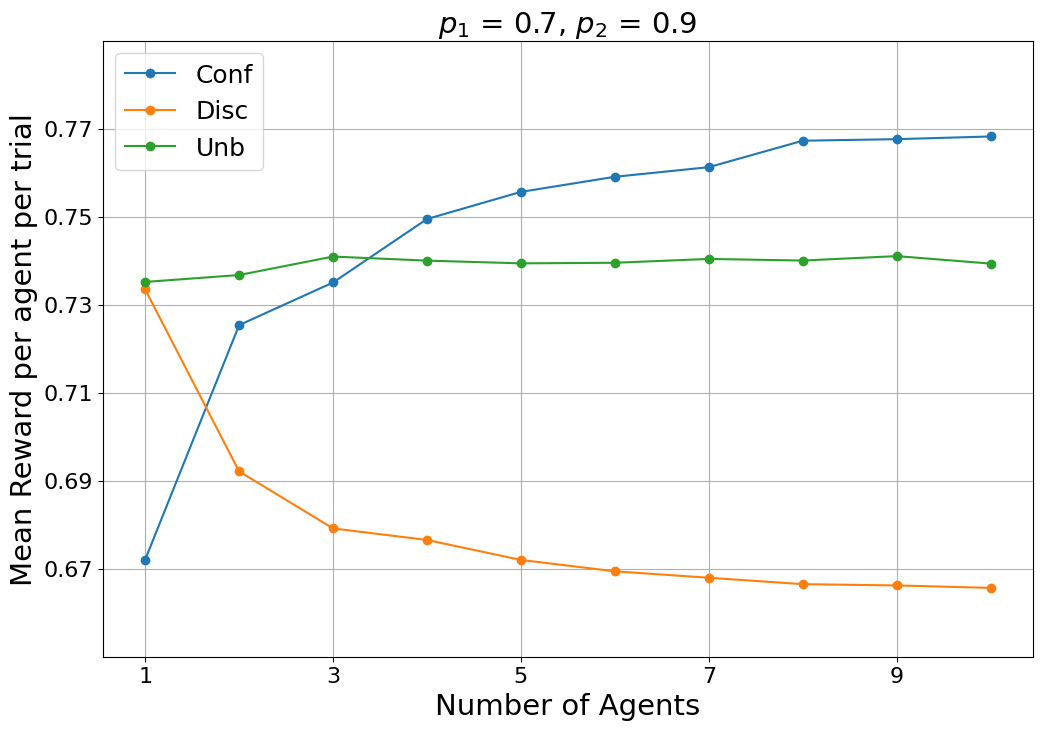

In [44]:
plt.figure(figsize=(12, 8))
lr = round(min(cperf+acperf+nperf),2)
mr = round(max(cperf+acperf+nperf),2)
plt.plot(ns,cperf,"o-",label = "Conf")
plt.plot(ns,acperf,"o-",label = "Disc")
plt.plot(ns,nperf,"o-",label = "Unb")
plt.legend(fontsize = 18)
plt.xlabel("Number of Agents",fontsize = 21)
plt.ylabel("Mean Reward per agent per trial",fontsize = 21)
plt.title(r"$p_1$ = "+str(p1)+r", $p_2$ = "+str(p2),fontsize = 21)
plt.xticks(list(range(1,ns[-1],2)),fontsize = 16)
plt.yticks(np.arange(lr,mr+0.02,0.02),fontsize = 16)
plt.ylim([lr-0.02,mr+0.02])
plt.grid()
plt.savefig("Fig1E.jpg",dpi = 500)

## Abundant conditions, $p_1$ = 0.7, $p_2$ = 0.9, confirmatory bias, b = 9, 1, $\frac{1}{9}$

In [47]:
#Simulation Parameters for confirmation bias

ns = list(range(1,11)) #Number of Agents used from prev simulation
t = 200 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.18 #confirmatory learning rate
alpha2 = 0.02 #anti-conrfirmatory learning rate
K = 500 #number of simulations

cperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    cperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for disconfirmation bias

alpha1 = 0.02 #confirmatory learning rate
alpha2 = 0.18 #anti-conrfirmatory learning rate

acperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    acperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

#Simulation Parameters for no bias

alpha1 = 0.1 #confirmatory learning rate
alpha2 = 0.1 #anti-conrfirmatory learning rate

nperf = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    nperf.append(simulateKtimes(K,ns[item],t,alpha1,alpha2,beta))

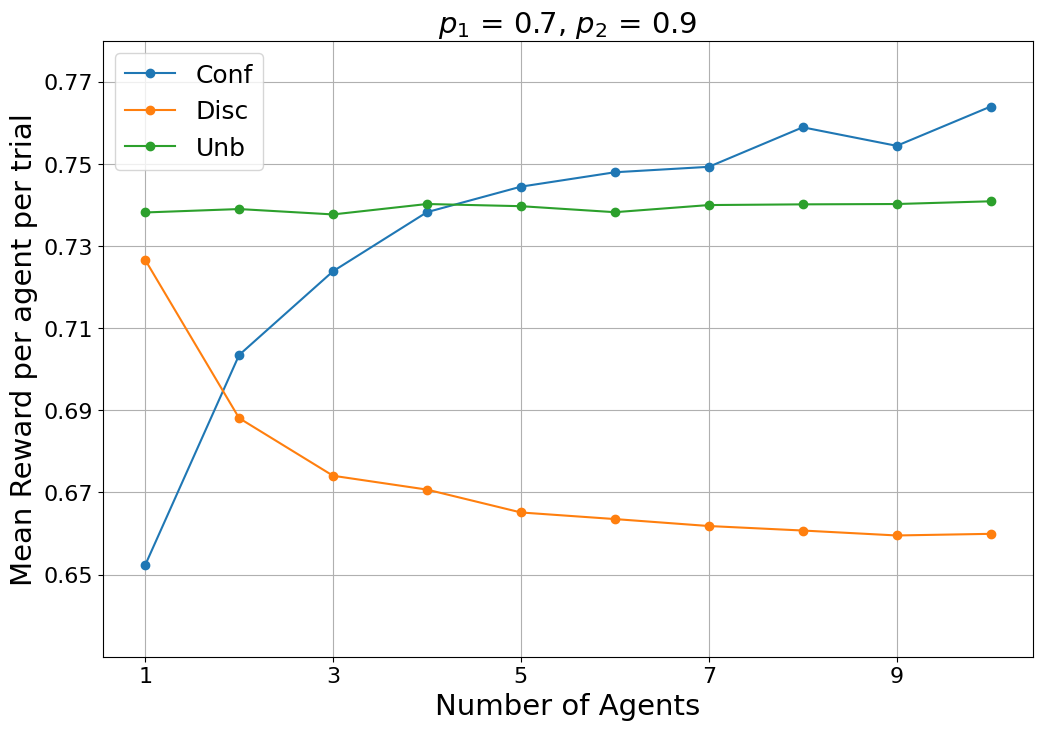

In [48]:
plt.figure(figsize=(12, 8))
lr = round(min(cperf+acperf+nperf),2)
mr = round(max(cperf+acperf+nperf),2)
plt.plot(ns,cperf,"o-",label = "Conf")
plt.plot(ns,acperf,"o-",label = "Disc")
plt.plot(ns,nperf,"o-",label = "Unb")
plt.legend(fontsize = 18)
plt.xlabel("Number of Agents",fontsize = 21)
plt.ylabel("Mean Reward per agent per trial",fontsize = 21)
plt.title(r"$p_1$ = "+str(p1)+r", $p_2$ = "+str(p2),fontsize = 21)
plt.xticks(list(range(1,ns[-1],2)),fontsize = 16)
plt.yticks(np.arange(lr,mr+0.02,0.02),fontsize = 16)
plt.ylim([lr-0.02,mr+0.02])
plt.grid()
plt.savefig("Fig1F.jpg",dpi = 500)

## $\Delta Q$ distribution for abundant conditions and no bias 

In [ ]:
def softmax_mod(dQ,a_beta): 
    val = 1/(1+np.exp(-a_beta*(dQ))) #returns the softmax values
    return val

def multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta):
    net_reward = 0
    for i in range(t):
        Qval2 = np.copy(Qval)
        rewards = []
        actions = []
        b1_w = []
        b2_w = []
        b1_l = []
        b2_l = []
        for agent_id in range(n):
            action = return_action(agent_id,Qval,beta) #find the action and rewards of the agents
            reward = bandit_reward(action)
            actions.append(action)
            rewards.append(reward)
            if action == 0 and reward == -1: #classify the agents according to the action and rewards
                b1_l.append(agent_id)
            elif action == 0 and reward == 1:
                b1_w.append(agent_id)
            elif action == 1 and reward == -1:
                b2_l.append(agent_id)
            elif action==1 and reward == 1:
                b2_w.append(agent_id)
        net_reward+=sum(rewards)/n
        for agent_id in range(n): #update the q-values for the agent
            aic = actions[agent_id]
            if aic == 0: #set the sets of reward or penalty and action chosen or not chosen for particular agent
                Ric = b1_w
                Pic = b1_l
                Riu = b2_w
                Piu = b2_l
            else:
                Ric = b2_w
                Pic = b2_l
                Riu = b1_w
                Piu = b1_l
            Uc = calculateUc(Ric,Pic,alpha1,alpha2,Qval,n,aic,agent_id) #calculate the changes in Q's
            Uu = calculateUu(Riu,Piu,alpha1,alpha2,Qval,n,aic,agent_id)
            Qval2[agent_id,aic]+=Uc #update the Q values
            Qval2[agent_id,1-aic]+=Uu
        Qval = Qval2
    return (Qval[0,1]-Qval[0,0]),softmax_mod(Qval[0,1]-Qval[0,0],beta[0]) #return Q value gap and behaviour profile

def simulateKtimes(K,n,t,alpha1,alpha2,beta): #simulate for K times
    dQ_simuls = []
    for k in range(K):
        Qval = np.zeros((n,2)) #array to store the Q-values
        dQ_simuls.append(list(multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta)))
    return dQ_simuls


In [ ]:
#Simulation Parameters 

ns = [2,5] 
t = 1000 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.1 #confirmatory learning rate
alpha2 = 0.1 #anti-conrfirmatory learning rate
K = 1000 #number of simulations

nperf_dQ = []
nperf_bP = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
    nperf_dQ.append([item[0] for item in x1])
    nperf_bP.append([item[1] for item in x1])


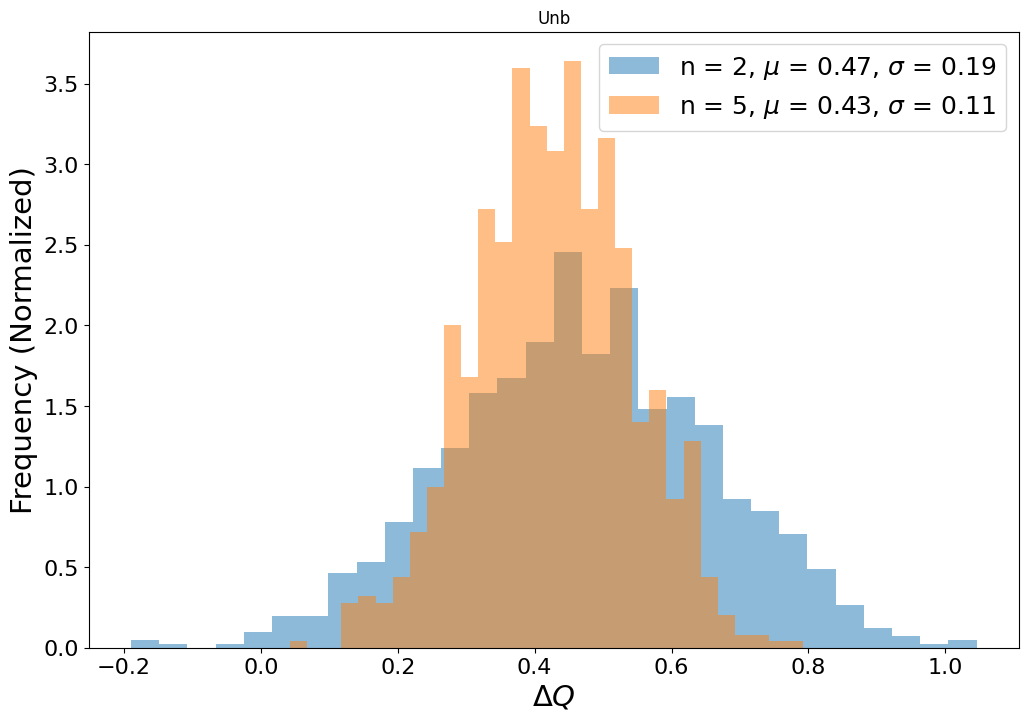

In [92]:
# Sample data
list1 = np.array(nperf_dQ[0])
list2 = np.array(nperf_dQ[1])
mu1 = round(np.mean(list1),2)
sigma1 = round(np.var(list1)**0.5,2)
mu2 = round(np.mean(list2),2)
sigma2 = round(np.var(list2)**0.5,2)

# Plot histograms with normalization
plt.figure(figsize=(12, 8))
plt.hist(list1, bins=30, alpha=0.5, label=r'n = 2, $\mu$ = '+str(mu1)+r', $\sigma$ = '+str(sigma1), density=True)
plt.hist(list2, bins=30, alpha=0.5, label=r'n = 5, $\mu$ = '+str(mu2)+r', $\sigma$ = '+str(sigma2), density=True)
#plt.xlim([-1,2])
# Add labels and legend
plt.xlabel(r'$\Delta Q$',fontsize = 21)
plt.ylabel('Frequency (Normalized)', fontsize = 21)
plt.legend(fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Unb')
plt.savefig("Fig2A.jpg",dpi = 500)
#plt.show()

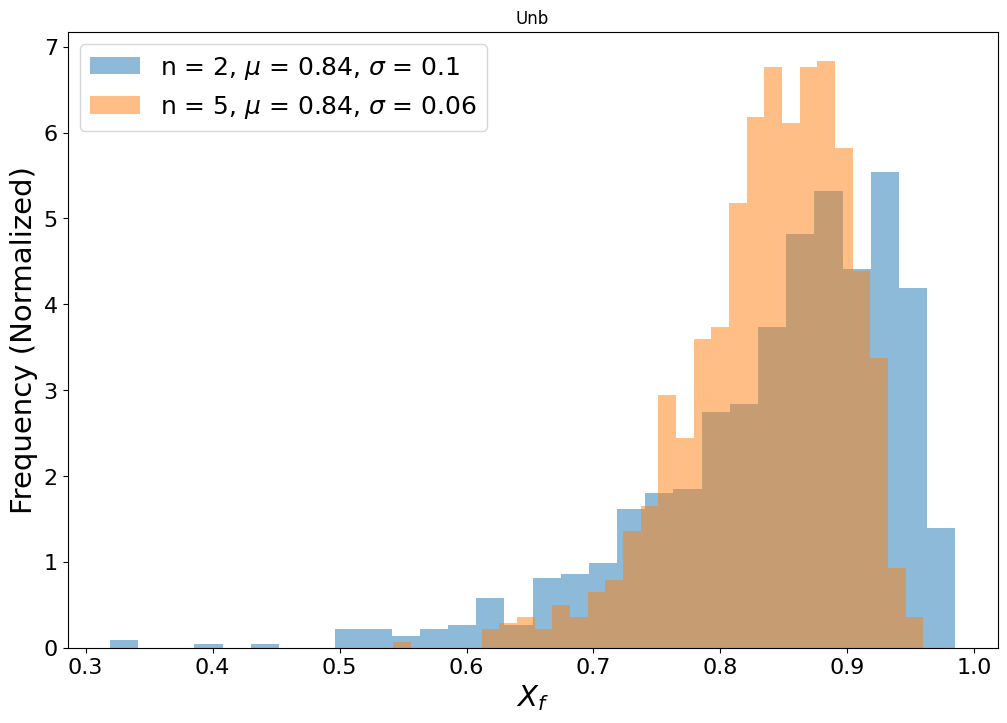

In [93]:
# Sample data
list1 = np.array(nperf_bP[0])
list2 = np.array(nperf_bP[1])
mu1 = round(np.mean(list1),2)
sigma1 = round(np.var(list1)**0.5,2)
mu2 = round(np.mean(list2),2)
sigma2 = round(np.var(list2)**0.5,2)

# Plot histograms with normalization
plt.figure(figsize=(12, 8))
plt.hist(list1, bins=30, alpha=0.5, label=r'n = 2, $\mu$ = '+str(mu1)+r', $\sigma$ = '+str(sigma1), density=True)
plt.hist(list2, bins=30, alpha=0.5, label=r'n = 5, $\mu$ = '+str(mu2)+r', $\sigma$ = '+str(sigma2), density=True)
#plt.xlim([-1,2])
# Add labels and legend
plt.xlabel(r'$X_f$',fontsize = 21)
plt.ylabel('Frequency (Normalized)', fontsize = 21)
plt.legend(fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Unb')
plt.savefig("Fig2D.jpg",dpi = 500)
#plt.show()

## $\Delta Q$ distribution for abundant conditions and small confirmation bias 

In [ ]:
#Simulation Parameters 
ns = [2,5] 
t = 1000 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 1000 #number of simulations

cperf_dQ = []
cperf_bP = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
    cperf_dQ.append([item[0] for item in x1])
    cperf_bP.append([item[1] for item in x1])

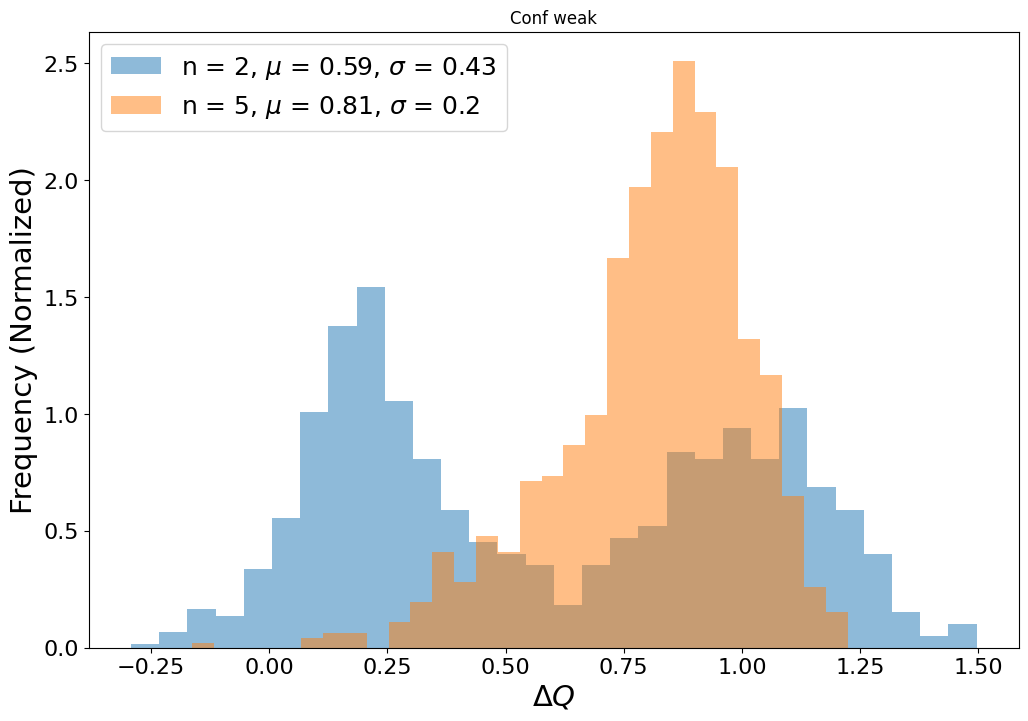

In [95]:
# Sample data
list1 = np.array(cperf_dQ[0])
list2 = np.array(cperf_dQ[1])
mu1 = round(np.mean(list1),2)
sigma1 = round(np.var(list1)**0.5,2)
mu2 = round(np.mean(list2),2)
sigma2 = round(np.var(list2)**0.5,2)

# Plot histograms with normalization
plt.figure(figsize=(12, 8))
plt.hist(list1, bins=30, alpha=0.5, label=r'n = 2, $\mu$ = '+str(mu1)+r', $\sigma$ = '+str(sigma1), density=True)
plt.hist(list2, bins=30, alpha=0.5, label=r'n = 5, $\mu$ = '+str(mu2)+r', $\sigma$ = '+str(sigma2), density=True)
#plt.xlim([-1,2])
# Add labels and legend
plt.xlabel(r'$\Delta Q$',fontsize = 21)
plt.ylabel('Frequency (Normalized)', fontsize = 21)
plt.legend(fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Conf weak')
plt.savefig("Fig2B.jpg",dpi = 500)
#plt.show()

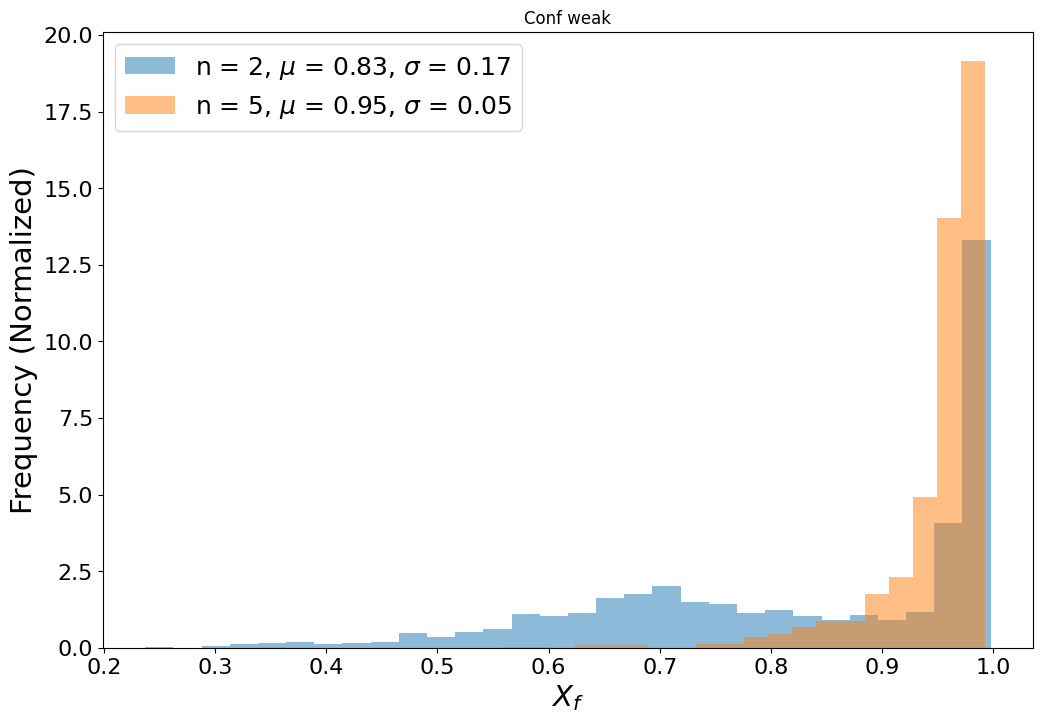

In [96]:
# Sample data
list1 = np.array(cperf_bP[0])
list2 = np.array(cperf_bP[1])
mu1 = round(np.mean(list1),2)
sigma1 = round(np.var(list1)**0.5,2)
mu2 = round(np.mean(list2),2)
sigma2 = round(np.var(list2)**0.5,2)

# Plot histograms with normalization
plt.figure(figsize=(12, 8))
plt.hist(list1, bins=30, alpha=0.5, label=r'n = 2, $\mu$ = '+str(mu1)+r', $\sigma$ = '+str(sigma1), density=True)
plt.hist(list2, bins=30, alpha=0.5, label=r'n = 5, $\mu$ = '+str(mu2)+r', $\sigma$ = '+str(sigma2), density=True)
#plt.xlim([-1,2])
# Add labels and legend
plt.xlabel(r'$X_f$',fontsize = 21)
plt.ylabel('Frequency (Normalized)', fontsize = 21)
plt.legend(fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Conf weak')
plt.savefig("Fig2E.jpg",dpi = 500)
#plt.show()

## $\Delta Q$ distribution for abundant conditions and small confirmation bias 

In [ ]:
#Simulation Parameters 

ns = [2,5] 
t = 1000 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
alpha1 = 0.18 #confirmatory learning rate
alpha2 = 0.02 #anti-conrfirmatory learning rate
K = 1000 #number of simulations

cperf_dQ = []
cperf_bP = []
for item in range(len(ns)):
    #print(ns[item])
    beta = betas[item]
    x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
    cperf_dQ.append([item[0] for item in x1])
    cperf_bP.append([item[1] for item in x1])

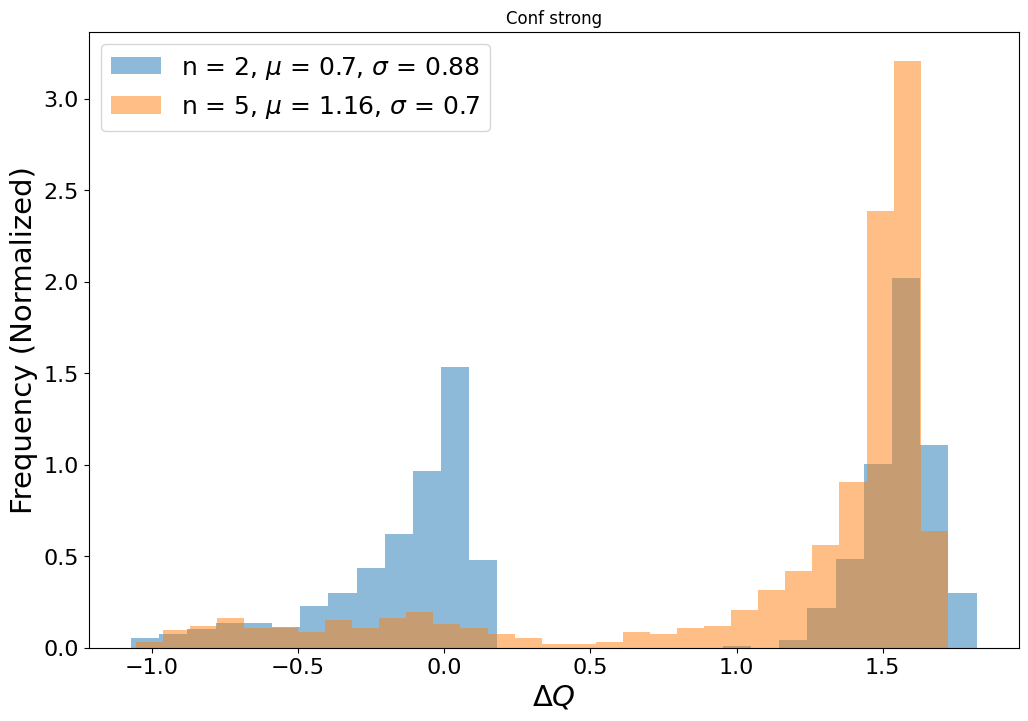

In [98]:
# Sample data
list1 = np.array(cperf_dQ[0])
list2 = np.array(cperf_dQ[1])
mu1 = round(np.mean(list1),2)
sigma1 = round(np.var(list1)**0.5,2)
mu2 = round(np.mean(list2),2)
sigma2 = round(np.var(list2)**0.5,2)

# Plot histograms with normalization
plt.figure(figsize=(12, 8))
plt.hist(list1, bins=30, alpha=0.5, label=r'n = 2, $\mu$ = '+str(mu1)+r', $\sigma$ = '+str(sigma1), density=True)
plt.hist(list2, bins=30, alpha=0.5, label=r'n = 5, $\mu$ = '+str(mu2)+r', $\sigma$ = '+str(sigma2), density=True)
#plt.xlim([-1,2])
# Add labels and legend
plt.xlabel(r'$\Delta Q$',fontsize = 21)
plt.ylabel('Frequency (Normalized)', fontsize = 21)
plt.legend(fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Conf strong')
plt.savefig("Fig2C.jpg",dpi = 500)
#plt.show()

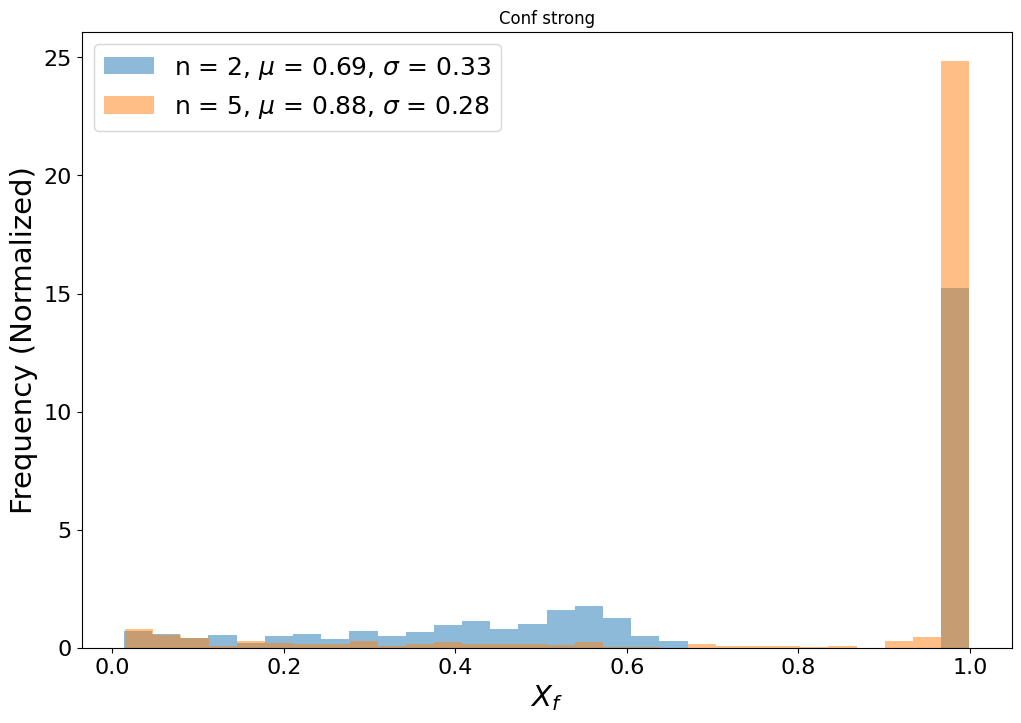

In [99]:
# Sample data
list1 = np.array(cperf_bP[0])
list2 = np.array(cperf_bP[1])
mu1 = round(np.mean(list1),2)
sigma1 = round(np.var(list1)**0.5,2)
mu2 = round(np.mean(list2),2)
sigma2 = round(np.var(list2)**0.5,2)

# Plot histograms with normalization
plt.figure(figsize=(12, 8))
plt.hist(list1, bins=30, alpha=0.5, label=r'n = 2, $\mu$ = '+str(mu1)+r', $\sigma$ = '+str(sigma1), density=True)
plt.hist(list2, bins=30, alpha=0.5, label=r'n = 5, $\mu$ = '+str(mu2)+r', $\sigma$ = '+str(sigma2), density=True)
#plt.xlim([-1,2])
# Add labels and legend
plt.xlabel(r'$X_f$',fontsize = 21)
plt.ylabel('Frequency (Normalized)', fontsize = 21)
plt.legend(fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Conf strong')
plt.savefig("Fig2F.jpg",dpi = 500)
#plt.show()